# California ISO EMS Load Data Analysis

In [9]:
# Step 1: Import libraries
import pandas as pd
import requests
from bs4 import BeautifulSoup
from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [10]:
# Step 2: Scrape the page for the last 10 months of EMS load data plus last 3 months of 2024
base_url = "https://www.caiso.com"
data_page = "https://www.caiso.com/library/historical-ems-hourly-load"
response = requests.get(data_page)
soup = BeautifulSoup(response.content, "html.parser")

# Step 3: Extract links and filter for desired months
links = soup.find_all("a", href=True)
data_links = []
for link in links:
    href = link["href"]
    text = link.text.strip()
    if "Historical EMS Hourly Load for" in text and href.endswith(".pdf") is False:
        # Extract date from text
        try:
            date_str = text.split("for")[-1].strip()
            date_obj = datetime.strptime(date_str, "%B %Y")
            
            # Include last 10 months of 2025 and last 3 months of 2024
            is_recent_2025 = (date_obj.year == 2025 and (datetime.now() - date_obj).days <= 310)
            is_late_2024 = (date_obj.year == 2024 and date_obj.month >= 10)  # October through December
            
            if is_recent_2025 or is_late_2024:
                data_links.append((text, base_url + href))
        except:
            continue

# Sort links by date
data_links.sort(key=lambda x: datetime.strptime(x[0].split("for")[-1].strip(), "%B %Y"))

In [11]:
# Step 4: Download and save Excel files
import os

# Create Data directory if it doesn't exist
# Place Data folder relative to this notebook file
nb_dir = os.path.dirname(os.path.abspath('__file__'))
data_dir = os.path.join(nb_dir, 'Data')
os.makedirs(data_dir, exist_ok=True)

# Download and save files
# Use a distinct name for the list of DataFrames to avoid accidental overwrite
downloaded_dfs = []
for name, url in data_links:
    # Extract month and year from name for filename
    try:
        _, date_part = name.split("for")
        date_str = date_part.strip().replace(" ", "_").lower()
    except Exception:
        # Fallback: sanitize the whole name
        date_str = name.strip().replace(" ", "_").lower()
    filename = f"historical_ems_hourly_load_{date_str}.xlsx"
    filepath = os.path.join(data_dir, filename)
    
    print(f"Downloading: {name}")
    file_response = requests.get(url)
    file_response.raise_for_status()
    
    # Save the Excel file
    with open(filepath, 'wb') as f:
        f.write(file_response.content)
    print(f"Saved to: {filepath}")
    
    # Read the Excel file into DataFrame
    try:
        df = pd.read_excel(filepath)
    except Exception as e:
        print(f"Warning: failed to read {filepath} as Excel: {e}")
        continue
    df["Source"] = name
    downloaded_dfs.append(df)

Downloading: Historical EMS Hourly Load for October 2024
Saved to: c:\Users\phoen\OneDrive\Documents\ADS\ADS 506 Time-Series Analysis\PROJECT - ADS 506\Code\Data\historical_ems_hourly_load_october_2024.xlsx
Downloading: Historical EMS Hourly Load for November 2024
Saved to: c:\Users\phoen\OneDrive\Documents\ADS\ADS 506 Time-Series Analysis\PROJECT - ADS 506\Code\Data\historical_ems_hourly_load_november_2024.xlsx
Downloading: Historical EMS Hourly Load for November 2024
Saved to: c:\Users\phoen\OneDrive\Documents\ADS\ADS 506 Time-Series Analysis\PROJECT - ADS 506\Code\Data\historical_ems_hourly_load_november_2024.xlsx
Downloading: Historical EMS Hourly Load for December 2024
Saved to: c:\Users\phoen\OneDrive\Documents\ADS\ADS 506 Time-Series Analysis\PROJECT - ADS 506\Code\Data\historical_ems_hourly_load_december_2024.xlsx
Downloading: Historical EMS Hourly Load for January 2025
Downloading: Historical EMS Hourly Load for December 2024
Saved to: c:\Users\phoen\OneDrive\Documents\ADS\ADS

In [12]:
# Combine all downloaded DataFrames into one
# Use the downloaded_dfs list (created in the download cell)
if not downloaded_dfs:
    raise ValueError("No DataFrames were downloaded - check the previous cell and data_links.")

raw_df = pd.concat(downloaded_dfs, ignore_index=True)

# Quick info
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8782 entries, 0 to 8781
Data columns (total 10 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Date                                        8771 non-null   object 
 1   HR                                          8760 non-null   float64
 2   PGE                                         8760 non-null   float64
 3   SCE                                         8760 non-null   float64
 4   SDGE                                        8760 non-null   float64
 5   VEA                                         8760 non-null   float64
 6   CAISO                                       8760 non-null   float64
 7   Source                                      8782 non-null   object 
 8   Unnamed: 7                                  0 non-null      float64
 9   Spring DST change occurs on March 9 in HE2  0 non-null      float64
dtypes: float64(8

In [13]:
# Basic inspection
print("DataFrame Info:")
print(raw_df.info())
print("\nDataFrame Head:")
print(raw_df.head())

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8782 entries, 0 to 8781
Data columns (total 10 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Date                                        8771 non-null   object 
 1   HR                                          8760 non-null   float64
 2   PGE                                         8760 non-null   float64
 3   SCE                                         8760 non-null   float64
 4   SDGE                                        8760 non-null   float64
 5   VEA                                         8760 non-null   float64
 6   CAISO                                       8760 non-null   float64
 7   Source                                      8782 non-null   object 
 8   Unnamed: 7                                  0 non-null      float64
 9   Spring DST change occurs on March 9 in HE2  0 non-null      float64
d

In [14]:
# Missing values
print("\nMissing Values:")
print(raw_df.isnull().sum())

# Summary statistics
print("\nSummary Statistics:")
print(raw_df.describe())


Missing Values:
Date                                            11
HR                                              22
PGE                                             22
SCE                                             22
SDGE                                            22
VEA                                             22
CAISO                                           22
Source                                           0
Unnamed: 7                                    8782
Spring DST change occurs on March 9 in HE2    8782
dtype: int64

Summary Statistics:
                HR           PGE           SCE         SDGE          VEA  \
count  8760.000000   8760.000000   8760.000000  8760.000000  8760.000000   
mean     12.499886  11111.626538  12336.508667  2231.642066    96.845187   
std       6.922763   1817.189322   2506.258446   411.347024    47.075573   
min       1.000000   5405.413776   7987.257223   914.825280     0.622185   
25%       6.750000   9891.468971  10483.502860  1968.785572

address missing values and spurious records in the combined DataFrame


In [15]:
# remove rows with missing or spurious 'Date' values
raw_df = raw_df[pd.to_datetime(raw_df["Date"], errors="coerce").notna()]

# Final check
print("Cleaned DataFrame Info:")
print(raw_df.info())


Cleaned DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 8760 entries, 0 to 8779
Data columns (total 10 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Date                                        8760 non-null   object 
 1   HR                                          8760 non-null   float64
 2   PGE                                         8760 non-null   float64
 3   SCE                                         8760 non-null   float64
 4   SDGE                                        8760 non-null   float64
 5   VEA                                         8760 non-null   float64
 6   CAISO                                       8760 non-null   float64
 7   Source                                      8760 non-null   object 
 8   Unnamed: 7                                  0 non-null      float64
 9   Spring DST change occurs on March 9 in HE2  0 non-null      float6

mising values and spurious 'Date' entries removed.  

Next, indexing and creating an index based on the 'Date' and 'Hour' (HR) columns 



In [17]:
# Extract time features for modeling and EDA
#  Create a corrected timestamp from Date and HR
raw_df["timestamp"] = pd.to_datetime(raw_df["Date"]) + pd.to_timedelta(raw_df["HR"] - 1, unit="h")

# Step 2: Extract time features from the timestamp (not index yet)
raw_df["hour"] = raw_df["timestamp"].dt.hour
raw_df["day"] = raw_df["timestamp"].dt.day
raw_df["weekday"] = raw_df["timestamp"].dt.weekday  # Monday=0
raw_df["month"] = raw_df["timestamp"].dt.month
raw_df["year"] = raw_df["timestamp"].dt.year
raw_df["weekofyear"] = raw_df["timestamp"].dt.isocalendar().week
raw_df["is_weekend"] = raw_df["weekday"].isin([5, 6])
raw_df["season"] = raw_df["month"].map({
    12: "Winter", 1: "Winter", 2: "Winter",
    3: "Spring", 4: "Spring", 5: "Spring",
    6: "Summer", 7: "Summer", 8: "Summer",
    9: "Fall", 10: "Fall", 11: "Fall"
})



* Date column already contains full datetime strings like "2024-10-01 00:00:00" and  
HR column representing the hour ending (1–24), 
* we should adjust the timestamp to reflect the correct hour by subtracting 1 from HR. 
* Then, extract time features from that computed timestamp—not from the index yet—so the original structure is still flexible.

🔄 Timestamp Accuracy
* Date already includes a full datetime, but HR refines it to the hour ending.
* Subtracting 1 hour ensures the timestamp reflects the start of the hour, which is standard for time series modeling.

🧱 Feature Flexibility
* Extracting features from timestamp (rather than index) lets you keep the original DataFrame structure intact.
* Later timestamp can be set as index when needed for .resample(), .rolling(), or forecasting.

📊 Modeling Readiness
* These features support:
* Seasonality detection (hour, weekday, season)
* Temporal splits (month, year, weekofyear)
* Categorical encoding for ML models
* Visualizations like hourly load curves or seasonal trends

In [20]:
# Combine Date and HR into a precise timestamp
raw_df["timestamp"] = pd.to_datetime(raw_df["Date"]) + pd.to_timedelta(raw_df["HR"] - 1, unit="h")

# Set timestamp as index and sort
raw_df.set_index("timestamp", inplace=True)
raw_df.sort_index(inplace=True)

raw_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2024-10-01 00:00:00 to 2025-09-30 23:00:00
Data columns (total 18 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Date                                        8760 non-null   object 
 1   HR                                          8760 non-null   float64
 2   PGE                                         8760 non-null   float64
 3   SCE                                         8760 non-null   float64
 4   SDGE                                        8760 non-null   float64
 5   VEA                                         8760 non-null   float64
 6   CAISO                                       8760 non-null   float64
 7   Source                                      8760 non-null   object 
 8   Unnamed: 7                                  0 non-null      float64
 9   Spring DST change occurs on March 9 in HE2  0 non

# EDA

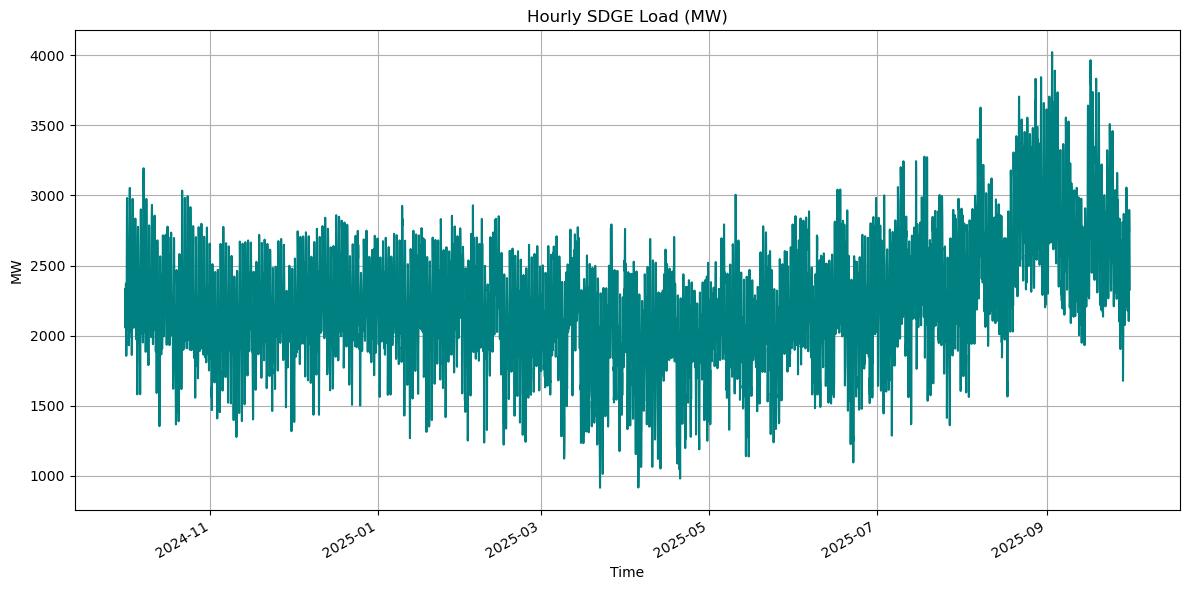

C:\Users\phoen\AppData\Local\Temp\ipykernel_22600\4144459823.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = raw_df["SDGE"].resample("M").mean()


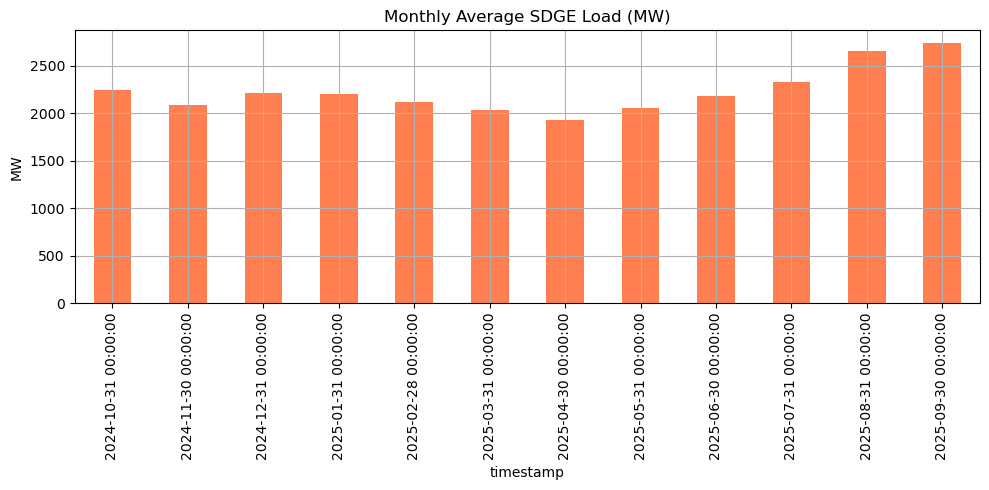

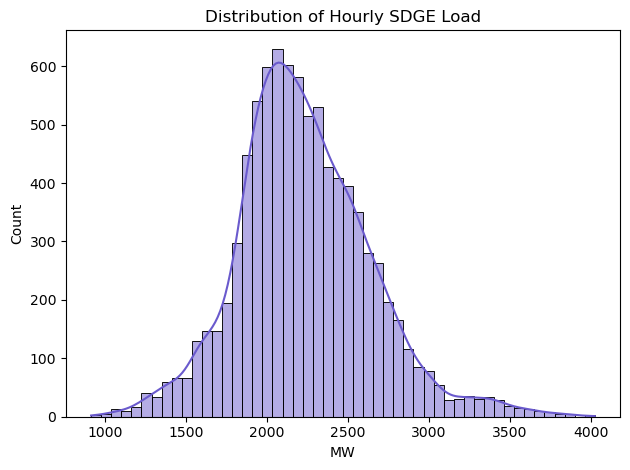

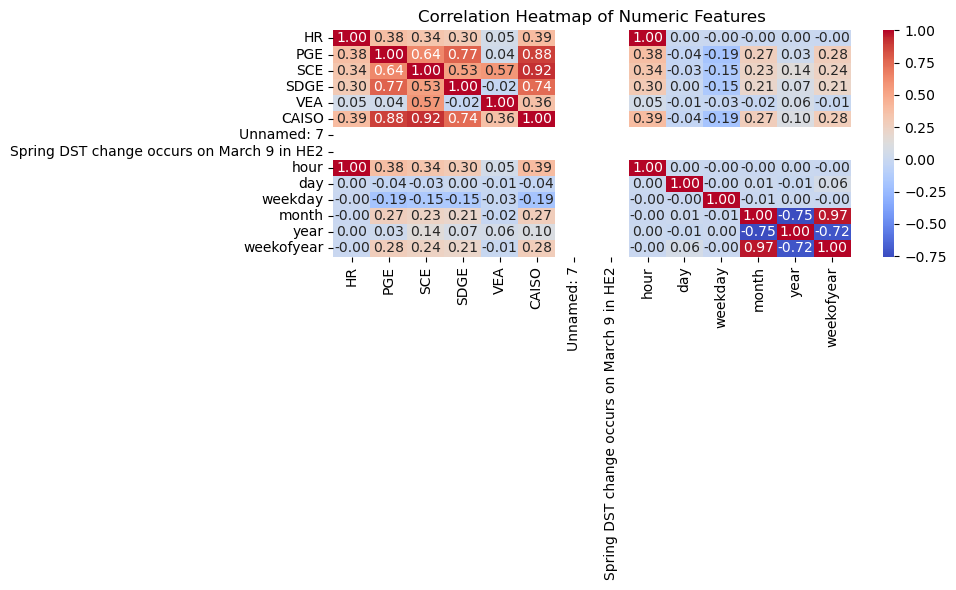

In [21]:
# Plotting: Hourly SDGE Load
plt.figure(figsize=(12, 6))
raw_df["SDGE"].plot(title="Hourly SDGE Load (MW)", color="teal")
plt.ylabel("MW")
plt.xlabel("Time")
plt.grid(True)
plt.tight_layout()
plt.show()

# Monthly average SDGE load
monthly_avg = raw_df["SDGE"].resample("M").mean()
monthly_avg.plot(kind="bar", title="Monthly Average SDGE Load (MW)", figsize=(10, 5), color="coral")
plt.ylabel("MW")
plt.grid(True)
plt.tight_layout()
plt.show()

# Distribution of SDGE load
sns.histplot(raw_df["SDGE"], bins=50, kde=True, color="slateblue")
plt.title("Distribution of Hourly SDGE Load")
plt.xlabel("MW")
plt.tight_layout()
plt.show()

# Correlation heatmap (numeric columns only)
numeric_cols = raw_df.select_dtypes(include="number")
if numeric_cols.shape[1] > 1:
    plt.figure(figsize=(10, 6))
    sns.heatmap(numeric_cols.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Heatmap of Numeric Features")
    plt.tight_layout()
    plt.show()
